<a href="https://colab.research.google.com/github/ah20776/CE802/blob/main/Results/CE802_P2_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
sys.path.append("../")

%matplotlib inline
import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

In [ ]:
#Importing dataset saved in github
!git clone https://github.com/ah20776/CE802.git

Cloning into 'CE802'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 59 (delta 29), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (59/59), done.


In [ ]:
#load P2 csv data
df = pd.read_csv('/content/CE802/CE802_P2_Data.csv')
df.head()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,Class
0,9.07,34.65,31.22,-10.71,55,39.45,-1.68,-5.98,3.72,20,16.23,-241.52,-7.54,13.70,-6.41,False
1,6.86,99.65,31.22,-11.41,50,30.45,5.55,-8.42,7.11,20,28.47,-421.52,-8.10,14.50,NaN,False
2,10.87,21.65,25.22,-5.98,12,2.91,9.81,-0.36,-12.66,2,30.87,-254.52,0.24,0.40,NaN,False
3,11.27,13.65,25.22,-6.18,33,1.77,1.92,1.84,-2.49,2,27.99,-234.52,0.20,0.30,NaN,False
4,10.19,27.65,29.22,-6.21,30,4.47,1.35,-0.50,-8.19,2,27.63,-266.52,0.44,1.76,NaN,True


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   F1      1500 non-null   float64
 1   F2      1500 non-null   float64
 2   F3      1500 non-null   float64
 3   F4      1500 non-null   float64
 4   F5      1500 non-null   int64  
 5   F6      1500 non-null   float64
 6   F7      1500 non-null   float64
 7   F8      1500 non-null   float64
 8   F9      1500 non-null   float64
 9   F10     1500 non-null   int64  
 10  F11     1500 non-null   float64
 11  F12     1500 non-null   float64
 12  F13     1500 non-null   float64
 13  F14     1500 non-null   float64
 14  F15     750 non-null    float64
 15  Class   1500 non-null   bool   
dtypes: bool(1), float64(13), int64(2)
memory usage: 177.4 KB


In [ ]:
data = df.dropna()
data = data.reset_index(drop=True)
data.describe()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15
count,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000
mean,9.018373,34.366000,36.985333,-9.104067,112.012000,15.333520,2.578080,-3.777760,1.023760,11.280000,24.108480,-303.842667,-3.874107,8.051253,-7.663013
std,2.514890,40.857245,14.212140,3.163011,118.027949,13.030635,3.318315,4.948743,7.448935,9.022387,7.535624,70.741542,5.092857,6.947930,1.005117
min,4.750000,-80.350000,19.220000,-15.410000,0.000000,0.000000,-4.230000,-12.520000,-21.240000,0.000000,10.500000,-461.520000,-12.640000,0.000000,-10.020000
25%,6.640000,14.650000,25.220000,-11.810000,16.000000,3.577500,0.630000,-8.300000,-4.980000,2.000000,16.920000,-366.520000,-8.650000,1.240000,-8.410000
50%,9.705000,28.650000,31.220000,-10.335000,54.000000,15.750000,2.160000,-2.790000,-0.825000,20.000000,25.965000,-267.520000,-2.610000,10.300000,-7.670000
75%,10.940000,49.650000,51.220000,-6.010000,200.000000,24.600000,4.312500,0.060000,8.130000,20.000000,29.880000,-246.520000,-0.145000,14.300000,-6.942500
max,16.800000,124.650000,71.220000,-5.260000,390.000000,47.100000,14.610000,10.640000,13.710000,20.000000,50.130000,-221.520000,12.580000,20.700000,-4.940000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   F1      750 non-null    float64
 1   F2      750 non-null    float64
 2   F3      750 non-null    float64
 3   F4      750 non-null    float64
 4   F5      750 non-null    int64  
 5   F6      750 non-null    float64
 6   F7      750 non-null    float64
 7   F8      750 non-null    float64
 8   F9      750 non-null    float64
 9   F10     750 non-null    int64  
 10  F11     750 non-null    float64
 11  F12     750 non-null    float64
 12  F13     750 non-null    float64
 13  F14     750 non-null    float64
 14  F15     750 non-null    float64
 15  Class   750 non-null    bool   
dtypes: bool(1), float64(13), int64(2)
memory usage: 88.7 KB


***DATA VISUALIZATION***

In [ ]:
data['Class'].value_counts()

False    406
True     344
Name: Class, dtype: int64

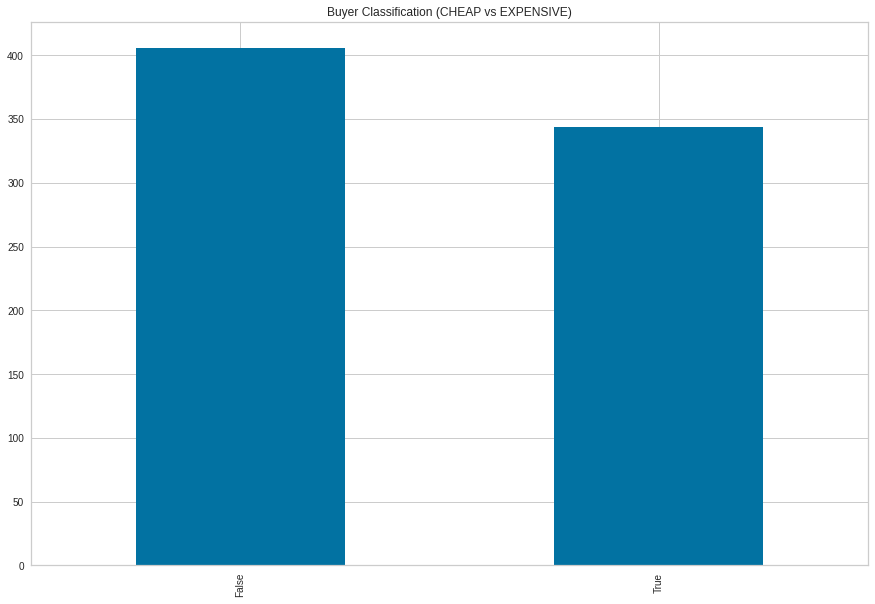

In [ ]:
data['Class'].value_counts().plot.bar(title='Buyer Classification (CHEAP vs EXPENSIVE)',figsize=(15,10));

***CROSS-VALIDATION AND ACCURACY***

In [ ]:
#Grid Search

from sklearn.model_selection import GridSearchCV
from sklearn import tree

parameters = {'max_depth':range(3,20)}
clf = GridSearchCV(tree.DecisionTreeClassifier(), parameters, n_jobs=4)
clf.fit(X, y)
tree_model = clf.best_estimator_
print (clf.best_score_, clf.best_params_)

0.8546666666666665 {'max_depth': 3}


In [ ]:
#remove F15 column altogether
df1 = df.drop('F15', 1)

X = df1.drop(['Class'], axis=1)
y = df1.Class

parameters = {'max_depth':range(3,20)}
clf = GridSearchCV(tree.DecisionTreeClassifier(), parameters, n_jobs=4)
clf.fit(X, y)
tree_model = clf.best_estimator_
print (clf.best_score_, clf.best_params_) 

0.7733333333333333 {'max_depth': 7}


In [ ]:
#now let's remove all records with missing values
df2 = df1.dropna()

X = df2.drop(['Class'], axis=1)
y = df2.Class

parameters = {'max_depth':range(3,20)}
clf = GridSearchCV(tree.DecisionTreeClassifier(), parameters, n_jobs=4)
clf.fit(X, y)
tree_model = clf.best_estimator_
print (clf.best_score_, clf.best_params_)

0.7746666666666667 {'max_depth': 10}


In [ ]:
#now let's try imputation of F15 with mean values

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.NaN, strategy='mean')

df3 = df

df3.F15 = imputer.fit_transform(df3['F15'].values.reshape(-1,1))[:,0]

df3.head()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,Class
0,9.07,34.65,31.22,-10.71,55,39.45,-1.68,-5.98,3.72,20,16.23,-241.52,-7.54,13.70,-6.410000,False
1,6.86,99.65,31.22,-11.41,50,30.45,5.55,-8.42,7.11,20,28.47,-421.52,-8.10,14.50,-7.663013,False
2,10.87,21.65,25.22,-5.98,12,2.91,9.81,-0.36,-12.66,2,30.87,-254.52,0.24,0.40,-7.663013,False
3,11.27,13.65,25.22,-6.18,33,1.77,1.92,1.84,-2.49,2,27.99,-234.52,0.20,0.30,-7.663013,False
4,10.19,27.65,29.22,-6.21,30,4.47,1.35,-0.50,-8.19,2,27.63,-266.52,0.44,1.76,-7.663013,True


In [ ]:
#checking performance of imputed dataset
X = df3.drop(['Class'], axis=1)
y = df3.Class

parameters = {'max_depth':range(3,20)}
clf = GridSearchCV(tree.DecisionTreeClassifier(), parameters, n_jobs=4)
clf.fit(X, y)
tree_model = clf.best_estimator_
print (clf.best_score_, clf.best_params_) 

0.8033333333333333 {'max_depth': 7}


In [ ]:
X = np.array(X)
y = np.array(y)

#using 5-fold cross validation
kf = KFold(5, shuffle=True, random_state=42)

cv_svm_accuracy  = []


for train_ind, val_ind in kf.split(X, y):
    # Assign CV IDX
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind]

    # Scale Data
    scaler = StandardScaler()
    X_train_scale = scaler.fit_transform(X_train)
    X_val_scale = scaler.transform(X_val) 

    #SVM Classification
    svm_clf = svm.SVC(kernel='linear').fit(X_train_scale, y_train)
    y_pred = svm_clf.predict(X_val_scale)
    cv_svm_accuracy.append(accuracy_score(y_val, y_pred))


print(f'SVM CV accuracy: {np.mean(cv_svm_accuracy):.3f} +- {np.std(cv_svm_accuracy):.3f}')

SVM CV accuracy: 0.839 +- 0.019


In [ ]:
cv_rf_accuracy  = []


for train_ind, val_ind in kf.split(X, y):
    # Assign CV IDX
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind]

    # Scale Data
    scaler = StandardScaler()
    X_train_scale = scaler.fit_transform(X_train)
    X_val_scale = scaler.transform(X_val) 

    #Random Forest classifier
    rf_clf=RandomForestClassifier(n_estimators=200).fit(X_train_scale, y_train)
    y_pred = rf_clf.predict(X_val_scale)
    cv_rf_accuracy.append(accuracy_score(y_val, y_pred))


print(f'Random Forest CV accuracy: {np.mean(cv_rf_accuracy):.3f} +- {np.std(cv_rf_accuracy):.3f}')

Random Forest CV accuracy: 0.863 +- 0.011


***a) Best performance - RANDOM FOREST CLASSIFIER with 86.3%***

***b) Prediction on hold-out test set.***

In [ ]:
# test data
df_test = pd.read_csv('/content/CE802/CE802_P2_Test.csv')
df_test.head()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,Class
0,6.64,59.65,51.22,-12.11,35,30.75,-2.94,-9.76,4.50,20,22.80,-296.52,-9.82,10.40,NaN,NaN
1,11.42,23.65,29.22,-5.98,1,0.84,5.79,2.52,-7.77,2,28.35,-244.52,0.70,1.18,-8.38,NaN
2,6.13,54.65,51.22,-12.41,55,27.75,-0.81,-10.20,11.07,20,14.88,-341.52,-10.06,13.30,NaN,NaN
3,6.68,9.65,51.22,-10.81,155,21.00,-2.61,-9.16,6.00,20,16.29,-291.52,-7.16,13.10,-6.68,NaN
4,10.74,24.65,25.22,-6.24,5,4.92,0.72,-1.72,-2.52,2,37.02,-271.52,-1.82,1.48,-8.57,NaN


In [ ]:
#impute F15 missing values with mean
df_test.F15 = imputer.fit_transform(df_test['F15'].values.reshape(-1,1))[:,0]
df_test.head()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,Class
0,6.64,59.65,51.22,-12.11,35,30.75,-2.94,-9.76,4.50,20,22.80,-296.52,-9.82,10.40,-7.696347,NaN
1,11.42,23.65,29.22,-5.98,1,0.84,5.79,2.52,-7.77,2,28.35,-244.52,0.70,1.18,-8.380000,NaN
2,6.13,54.65,51.22,-12.41,55,27.75,-0.81,-10.20,11.07,20,14.88,-341.52,-10.06,13.30,-7.696347,NaN
3,6.68,9.65,51.22,-10.81,155,21.00,-2.61,-9.16,6.00,20,16.29,-291.52,-7.16,13.10,-6.680000,NaN
4,10.74,24.65,25.22,-6.24,5,4.92,0.72,-1.72,-2.52,2,37.02,-271.52,-1.82,1.48,-8.570000,NaN


In [ ]:

X = df_test.drop(['Class'], axis=1)
y = df_test.Class

#convert data frame into np array
X = np.array(X)
y = np.array(y)

In [ ]:
# Standardize Data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
#using best model to predict test data labels
y_pred = rf_clf.predict(X_scaled)

df_test['Class'] = y_pred

df_test.head()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,Class
0,6.64,59.65,51.22,-12.11,35,30.75,-2.94,-9.76,4.50,20,22.80,-296.52,-9.82,10.40,-7.696347,False
1,11.42,23.65,29.22,-5.98,1,0.84,5.79,2.52,-7.77,2,28.35,-244.52,0.70,1.18,-8.380000,True
2,6.13,54.65,51.22,-12.41,55,27.75,-0.81,-10.20,11.07,20,14.88,-341.52,-10.06,13.30,-7.696347,True
3,6.68,9.65,51.22,-10.81,155,21.00,-2.61,-9.16,6.00,20,16.29,-291.52,-7.16,13.10,-6.680000,False
4,10.74,24.65,25.22,-6.24,5,4.92,0.72,-1.72,-2.52,2,37.02,-271.52,-1.82,1.48,-8.570000,True


***CE802_P2_TEST - DOWNLOAD***

In [ ]:
from google.colab import files
df_test.to_csv('CE802_P2_Test.csv') 
files.download('CE802_P2_Test.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>